In [1]:
import uproot
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import math
import random
import matplotlib.patches as mpatches
import re

from IPython.display import Image

import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
def round_to_2(x):
    return round(x, -int(math.floor(math.log10(abs(x))) - 1))

In [3]:
round_to_2(123)

120

In [4]:
def getListFromString(listLike, numList = False): 
    #takes a string read from a csv or something and turns it into an actual list
    bracket1 = listLike.find('[')
    bracket2 = listLike[bracket1 + 1:].find(']') + bracket1 + 1
    listLike = listLike[bracket1+1:bracket2].split()
    for n,item in enumerate(listLike):
        listLike[n] = float(item)
    return listLike

In [5]:
def collapse(lst): #if all elements of a list are the same, collapse the list into a single item
    try:
        iter(lst) #checks if the item is a list
    except:
        return lst
    
    
    for n,i in enumerate(lst[:-1]):
        if i != lst[n+1]:
            return lst
    return lst[0]

In [6]:
def extractCFFs(cffList):
    return str(cffList[:-1]).replace('[','').replace(']','')

In [7]:
BKM_finder = re.compile(r'\d+')
metrics_tot = pd.DataFrame()
actual_values_tot = pd.DataFrame()

for i in os.listdir():
    if 'metrics' in i and 'csv' in i:
        print('assembling metric using', i)
        BKM_num = int(BKM_finder.findall(i)[0])
        
        metrics = pd.read_csv(i)
        metrics['Calculated Points'] = metrics['Calculated Points'].apply(getListFromString)
        metrics['Calculated CFFs'] = metrics['Calculated CFFs'].apply(getListFromString)
        metrics = metrics.drop(columns=metrics.columns[0])
        metrics[['Epoch', 'Batch', 'Set']] = metrics[['Epoch', 'Batch', 'Set']].astype('int')
        metrics[['MAE', "Max Residual", 'NRMSE']] = metrics[['MAE', "Max Residual", 'NRMSE']].astype('float64')
        metrics['Set'] += 1
        metrics['BKM'] = BKM_num
        
        metrics_tot = pd.concat((metrics_tot, metrics))
        
os.chdir('test_data')
try:
    for i in os.listdir():
        if '.csv' in i and 'CFF' in i:
            print('Taking BKM pseudodata from',i)
            BKM_num = int(BKM_finder.findall(i)[0])

            actual_values = pd.read_csv(i)
            actual_values.rename(columns={"#Set":"Set", "ReHtilde":"ReHTilde"}, inplace=True)
            actual_values['Set'] = actual_values['Set'].astype(int)
            actual_values['BKM'] = BKM_num

            if not actual_values_tot.empty:
                actual_values = actual_values[actual_values_tot.columns]        
            actual_values_tot = pd.concat((actual_values_tot, actual_values))
            
    os.chdir('..')
except:
    os.chdir('..')
    print('error!')

assembling metric using metrics2.csv
assembling metric using metrics2_1.csv
assembling metric using metrics3.csv
assembling metric using metrics3_1.csv
Taking BKM pseudodata from BKM_pseudodata2_with_CFFS.csv
Taking BKM pseudodata from BKM_pseudodata3_with_CFFS.csv


In [8]:
actual_values_listified = pd.DataFrame(columns = actual_values_tot.columns)

for dataset in [2,3]:
    for i in range(1,actual_values_tot['Set'].max() + 1):
        tempdf = actual_values_tot.query('(Set==@i) & (BKM==@dataset)')
        tempdf = tempdf.stack().reset_index(level=0, drop=True)
        tempdf = tempdf.groupby(tempdf.index).apply(list).to_frame().transpose()
        actual_values_listified = pd.concat((actual_values_listified, tempdf), axis=0)
    
for column in actual_values_listified.columns:
    actual_values_listified[column] = actual_values_listified[column].apply(collapse)
actual_values = actual_values_listified
del actual_values_listified

In [9]:
overall = actual_values.merge(metrics_tot, on=['Set','BKM']).drop(columns=['index','k','QQ','x_b','t','F1','F2','dvcs'])
overall[['Calculated_ReH', 'Calculated_ReE', 'Calculated_ReHTilde']] = overall['Calculated CFFs'].apply(extractCFFs).str.split(',', expand=True).astype('float64')
overall.drop(columns=['Calculated CFFs'], inplace=True, axis=1)

for cff in ['ReH', 'ReE', 'ReHTilde']:
    overall['|\u0394' + cff + '|'] = (overall['Calculated_'+ cff] - overall[cff]).abs()
    
overall[['Set', 'BKM', 'Batch', 'Epoch']] = overall[['Set', 'BKM', 'Batch', 'Epoch']].astype(int)


In [23]:
overall['Epoch'].max()

30000

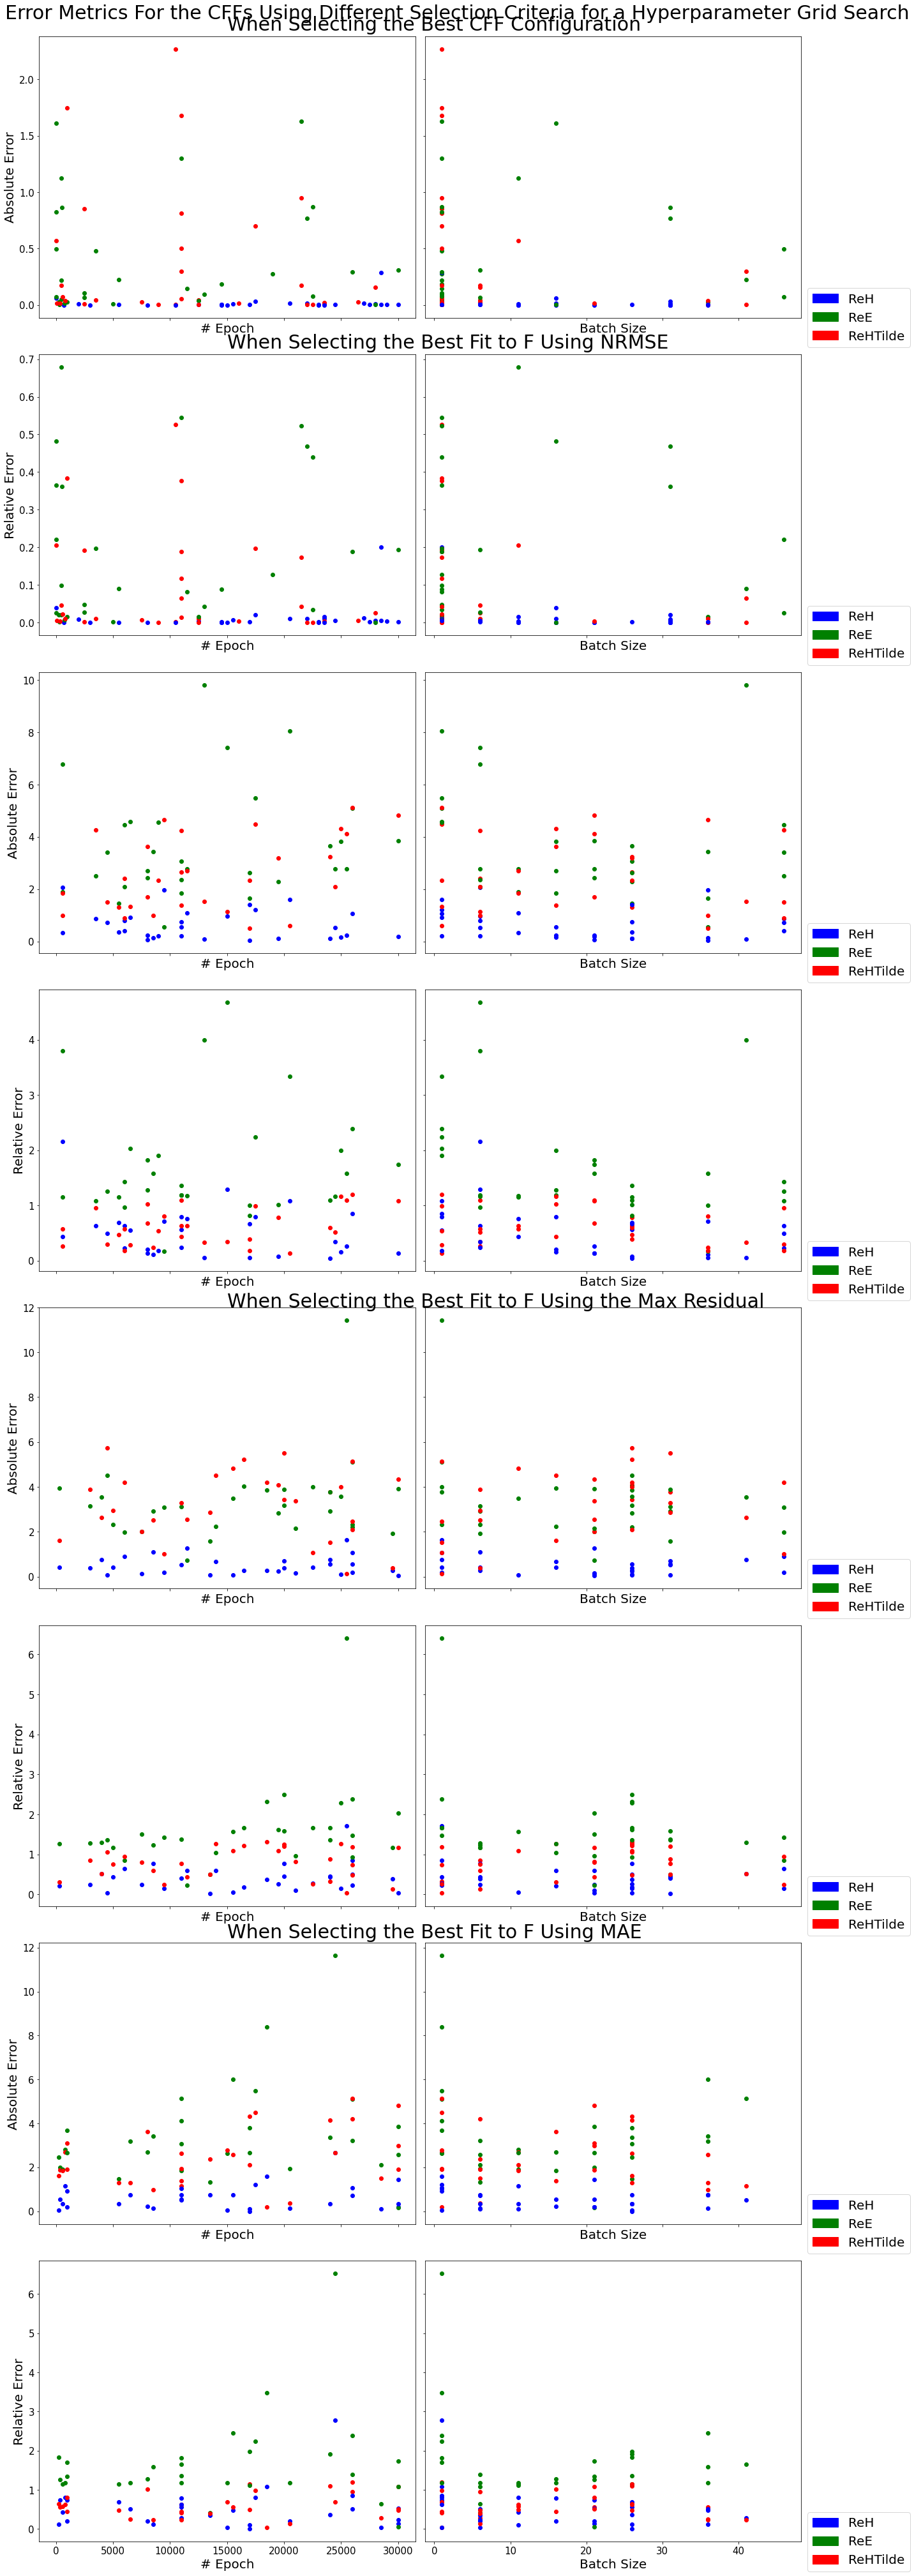

In [10]:
fig, ax = plt.subplots(8,2, figsize=(20,56), sharey='row', sharex='col');

for dataset in [2,3]:
    for i in np.arange(1, overall['Set'].max() + 1):
        tempdf = overall.query('(Set==@i) & (BKM==@dataset)')

        if tempdf.empty:
            continue

        for n, (cff, color) in enumerate(zip(['ReH', 'ReE', 'ReHTilde'], ['b','g','r'])):
            col_name = '|\u0394' + cff + '|'

            best_loc = tempdf[col_name].idxmin()
            best_loc = tempdf.loc[best_loc]

            best_loc_F_RMS = tempdf['NRMSE'].idxmin()
            best_loc_F_RMS = tempdf.loc[best_loc_F_RMS]

            best_loc_F_MAX_RES = tempdf['Max Residual'].idxmin()
            best_loc_F_MAX_RES = tempdf.loc[best_loc_F_MAX_RES]
            
            best_loc_F_MAE = tempdf['MAE'].idxmin()
            best_loc_F_MAE = tempdf.loc[best_loc_F_MAE]

            ax[0][0].set_ylabel('Absolute Error', fontsize=20); 
            ax[0][0].scatter(best_loc['Epoch'], best_loc[col_name], c=color);
        
            ax[0][1].scatter(best_loc['Batch'], best_loc[col_name], c=color);

            rel_err = abs(best_loc['Calculated_'+cff] - best_loc[cff])/abs(best_loc[cff])

            ax[1][0].set_ylabel('Relative Error', fontsize=20);
            ax[1][0].scatter(best_loc['Epoch'], rel_err, c=color);
            ax[1][0].set_xlabel('# Epochs', fontsize=20);

            ax[1][1].scatter(best_loc['Batch'], rel_err, c=color);
            ax[1][1].set_xlabel('Batch #', fontsize=20);

            ax[2][0].set_ylabel('Absolute Error', fontsize=20);

            rel_err = abs(best_loc_F_RMS['Calculated_'+cff] - best_loc_F_RMS[cff])/abs(best_loc_F_RMS[cff])

            ax[2][0].scatter(best_loc_F_RMS['Epoch'], best_loc_F_RMS[col_name], c=color);
            ax[2][0].set_ylabel('Absolute Error', fontsize=20); 
            ax[2][1].scatter(best_loc_F_RMS['Batch'], best_loc_F_RMS[col_name], c=color);

            ax[3][0].scatter(best_loc_F_RMS['Epoch'], rel_err, c=color);
            ax[3][0].set_ylabel('Relative Error', fontsize=20);
            ax[3][1].scatter(best_loc_F_RMS['Batch'], rel_err, c=color);

            ax[4][0].scatter(best_loc_F_MAX_RES['Epoch'], best_loc_F_MAX_RES[col_name], c=color);
            ax[4][0].set_ylabel('Absolute Error', fontsize=20); 
            ax[4][1].scatter(best_loc_F_MAX_RES['Batch'], best_loc_F_MAX_RES[col_name], c=color);

            rel_err = abs(best_loc_F_MAX_RES['Calculated_'+cff] - best_loc_F_MAX_RES[cff])/abs(best_loc_F_MAX_RES[cff])

            ax[5][0].scatter(best_loc_F_MAX_RES['Epoch'], rel_err, c=color);
            ax[5][0].set_ylabel('Relative Error', fontsize=20);
            ax[5][1].scatter(best_loc_F_MAX_RES['Batch'], rel_err, c=color);
            
            ax[6][0].scatter(best_loc_F_MAE['Epoch'], best_loc_F_MAE[col_name], c=color);
            ax[6][0].set_ylabel('Absolute Error', fontsize=20);
            ax[6][1].scatter(best_loc_F_MAE['Batch'], best_loc_F_MAE[col_name], c=color);
            
            rel_err = abs(best_loc_F_MAE['Calculated_'+cff] - best_loc_F_MAE[cff])/abs(best_loc_F_MAE[cff])
            
            ax[7][0].scatter(best_loc_F_MAE['Epoch'], rel_err, c=color);
            ax[7][0].set_ylabel('Relative Error', fontsize=20);
            ax[7][1].scatter(best_loc_F_MAE['Batch'], rel_err, c=color);


        for row in ax:
            row[0].set_xlabel('# Epoch', fontsize=20);
            row[1].set_xlabel('Batch Size', fontsize=20);
            row[1].legend(handles=[
                mpatches.Patch(color='b', label='ReH'),
                mpatches.Patch(color='g', label='ReE'),
                mpatches.Patch(color='r', label='ReHTilde')],
                bbox_to_anchor=[1, 0], loc='center left',
                fontsize=20);
            
            for chart in row:
                chart.tick_params(axis='both', which='major', labelsize=15);
#                 chart.set_xscale('log');
    
fig.suptitle('Error Metrics For the CFFs Using Different Selection Criteria for a Hyperparameter Grid Search', 
             fontsize=30, y=1);
fig.text(0.25, 0.99, 'When Selecting the Best CFF Configuration', fontsize=30);
fig.text(0.25, 6.93/8, 'When Selecting the Best Fit to F Using NRMSE', fontsize=30);
fig.text(0.25, 3.95/8, 'When Selecting the Best Fit to F Using the Max Residual', fontsize=30);
fig.text(0.25, 1.99/8, 'When Selecting the Best Fit to F Using MAE', fontsize=30);
fig.patch.set_facecolor('white');
fig.tight_layout();
plt.show();
fig.savefig('Plots/CFFs_with_different_criteria.png', transparent=False, facecolor=fig.get_facecolor());

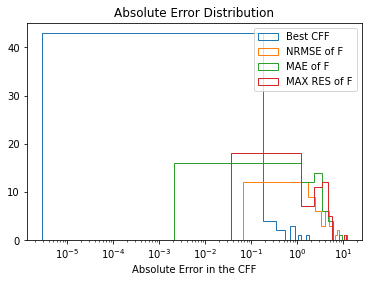

In [11]:
errorHist = pd.DataFrame(columns=["Best CFF", "NRMSE of F", "MAE of F", "MAX RES of F"])


for i in np.arange(1, overall['Set'].max() + 1):
    tempdf = overall.query('Set==@i')
    
    if tempdf.empty:
        continue
        
    for n, (cff, color) in enumerate(zip(['ReH', 'ReE', 'ReHTilde'], ['b','g','r'])):
        col_name = '|\u0394' + cff + '|'
        
        best_loc = tempdf[col_name].idxmin()
        best_loc = tempdf.loc[best_loc]
        
        best_loc_F_RMS = tempdf['NRMSE'].idxmin()
        best_loc_F_RMS = tempdf.loc[best_loc_F_RMS]
        
        best_loc_F_MAE = tempdf['MAE'].idxmin()
        best_loc_F_MAE = tempdf.loc[best_loc_F_MAE]
        
        best_loc_F_MAX_RES = tempdf['Max Residual'].idxmin()
        best_loc_F_MAX_RES = tempdf.loc[best_loc_F_MAX_RES]
                
        errorHist = pd.concat((errorHist, 
                         pd.DataFrame(
                             [[best_loc[col_name],
                                best_loc_F_RMS[col_name],
                                best_loc_F_MAE[col_name],
                                best_loc_F_MAX_RES[col_name]
                            ]], columns=errorHist.columns) ))

for n, (col_name, col) in enumerate(errorHist.iteritems()):
    plt.hist(col, label=col_name, histtype='step');

plt.legend(loc='best');
plt.title('Absolute Error Distribution');
plt.xlabel('Absolute Error in the CFF');
plt.xscale('log');

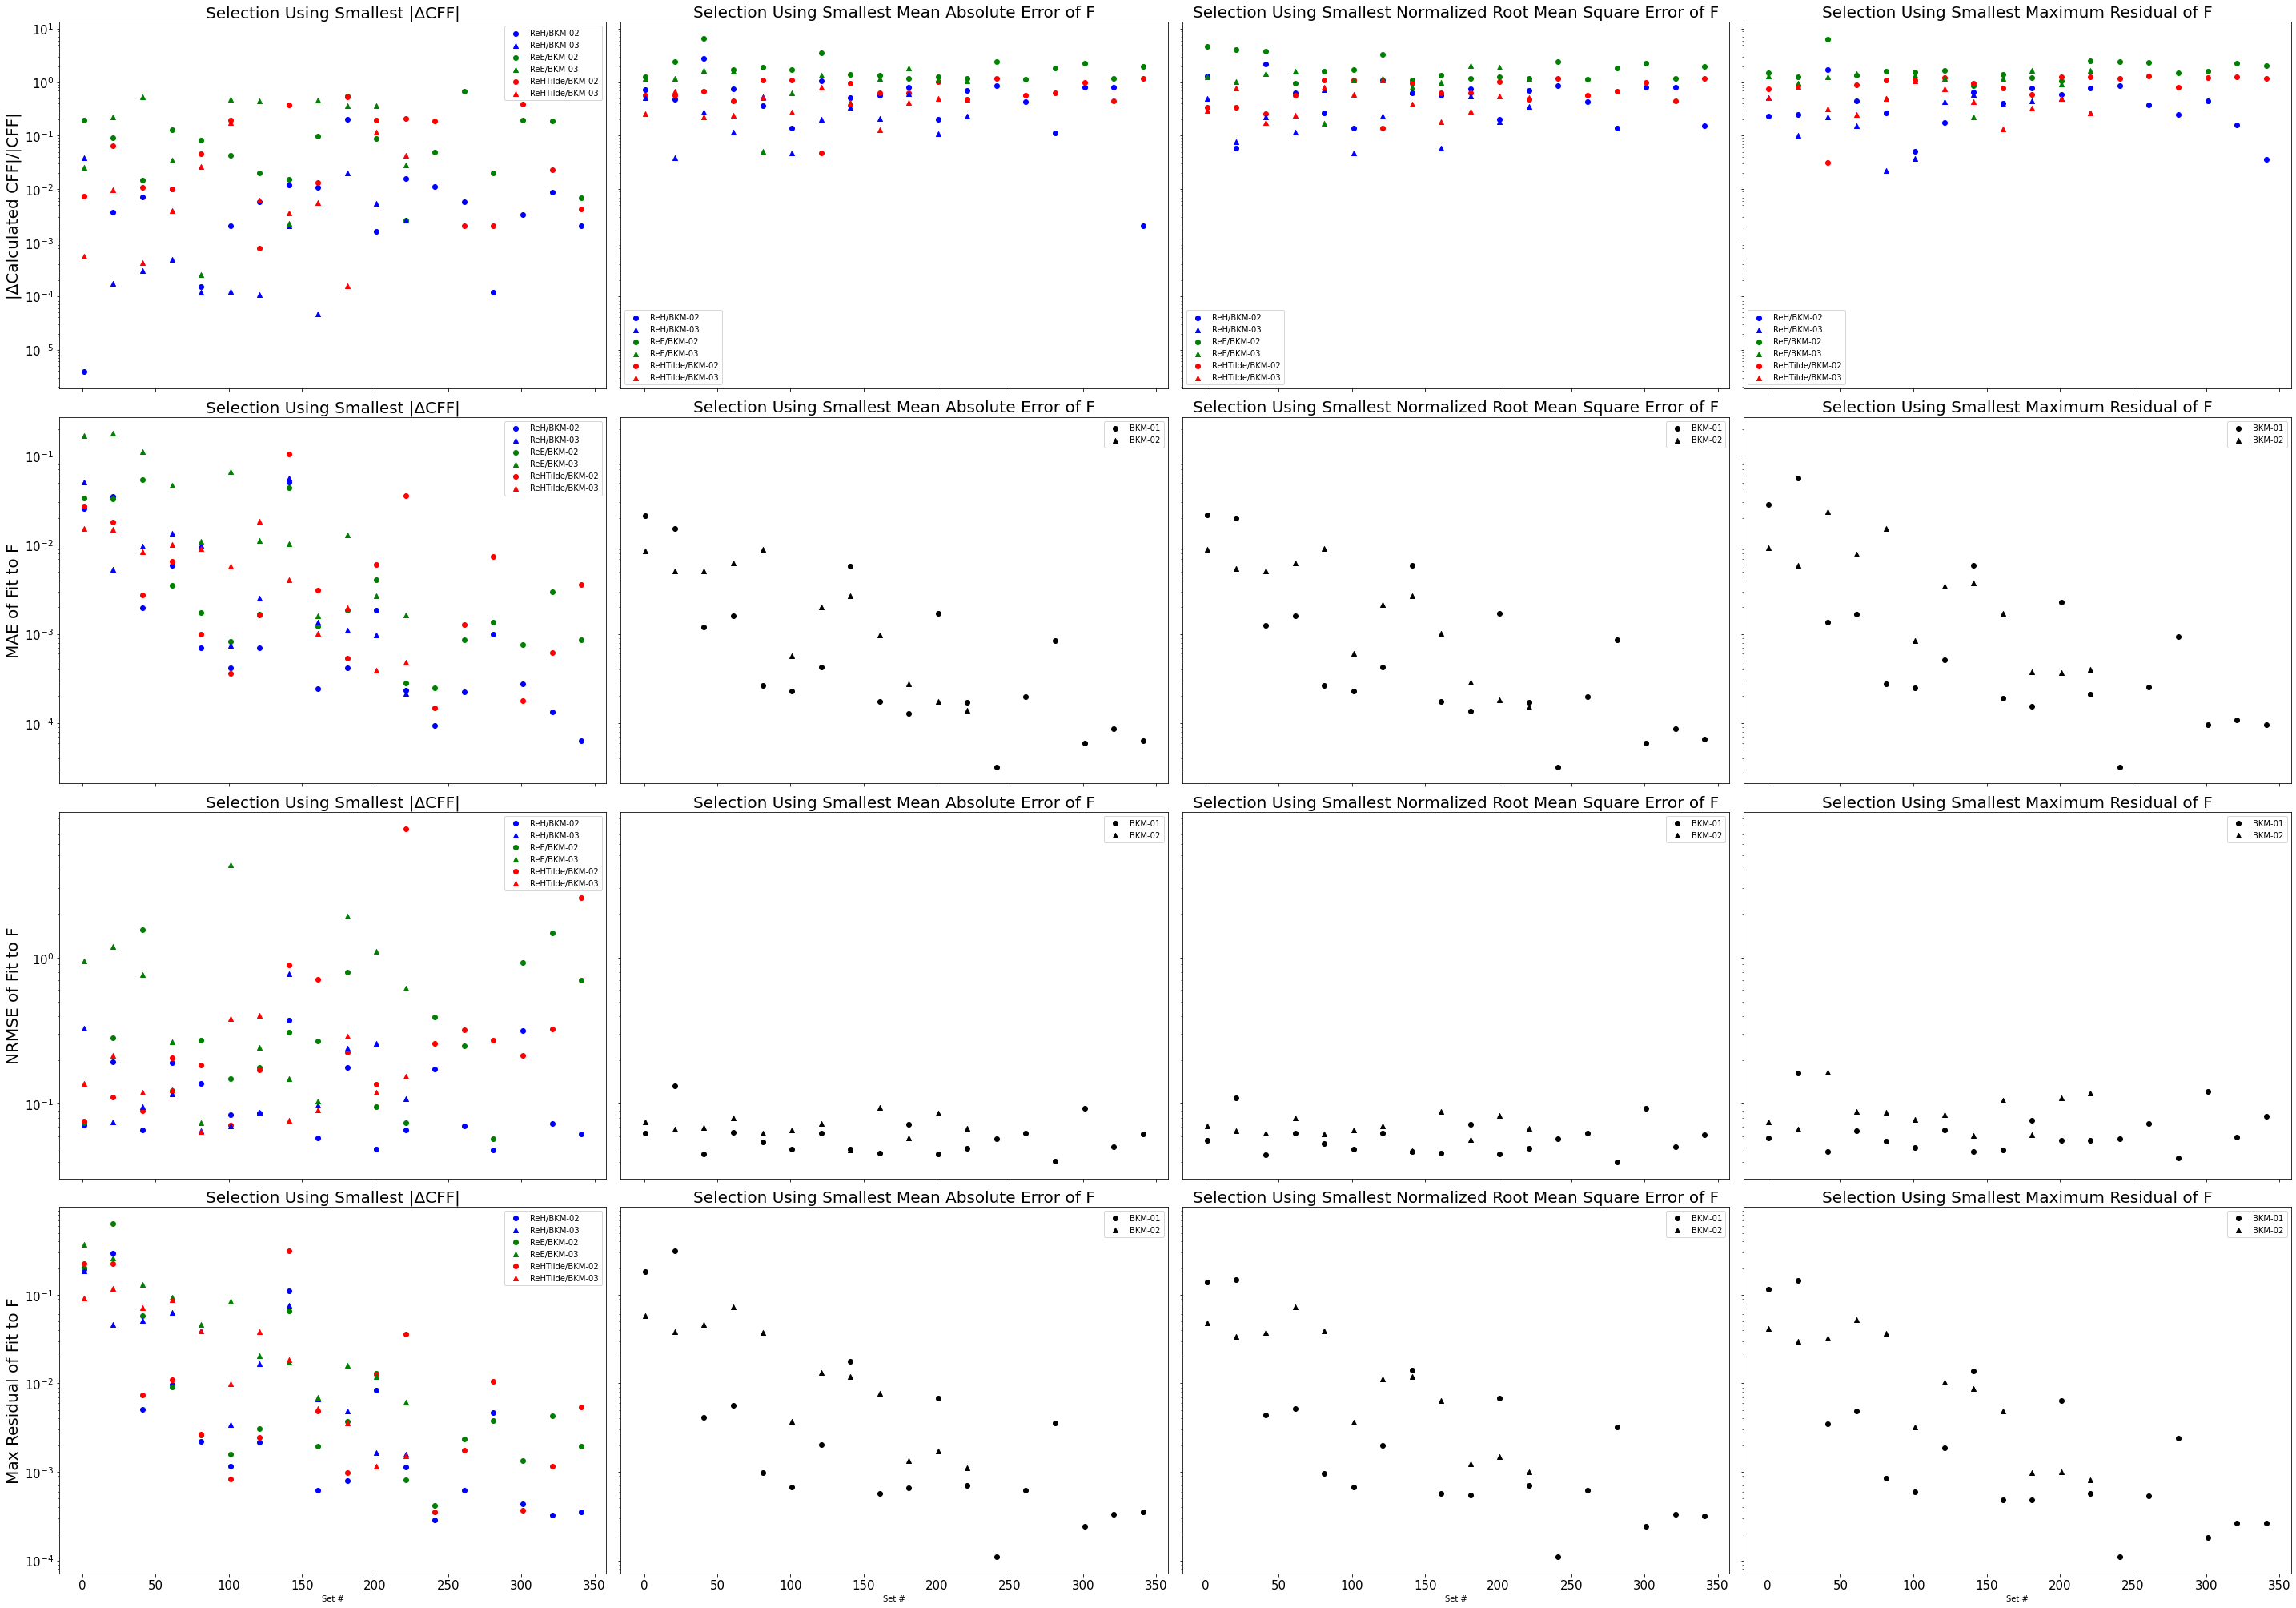

In [20]:
fig, ax = plt.subplots(4,4, figsize=(40,28), sharex='col', sharey='row');
titles_per_row = [
    ('CFF', 'CFF'), 
    ('Mean Absolute Error', 'MAE'), 
    ('Normalized Root Mean Square Error', 'NRMSE'), 
    ('Maximum Residual', 'Max Residual')
    ]

measurement = [
    '|\u0394Calculated CFF|/|CFF|',
    'MAE',
    'NRMSE',
    'Max Residual'
]


legend_handles = []

for legend_handle_cff, legend_handle_color in zip(['ReH', 'ReE', 'ReHTilde'], ['b', 'g', 'r']):
    for legend_handle_marker, legend_handle_bkm in zip(['o','^'],[2,3]):
        legend_handles += [ax[0][2].scatter([],[], 
                            marker=legend_handle_marker,
                            label = legend_handle_cff + '/BKM-0' + str(legend_handle_bkm),
                            c=legend_handle_color)]
        
legend_handles += [ax[0][2].scatter([],[], marker='o', c='black', label='BKM-01')];
legend_handles += [ax[0][2].scatter([],[], marker='^', c='black', label='BKM-02')];    
        
        
for i,row in enumerate(ax):
    for j, plot in enumerate(row):
        if i == 0 or j == 0:
            plot.legend(handles = legend_handles[:-2], loc='best')
        else:
            plot.legend(handles = legend_handles[-2:], loc='best')


for bkm in [2,3]:
    for setNum in np.arange(1, overall['Set'].max() + 1):
        tempdf = overall.query('(Set==@setNum) & (BKM==@bkm)')

        if tempdf.empty:
            continue

        for i, (row, meas) in enumerate(zip(ax, measurement)):
            for j, (plot, title) in enumerate(zip(row, titles_per_row)):
                if i == 3:
                    plot.set_xlabel('Set #');
                
                plot.tick_params(axis='both', which='major', labelsize=15);
                plot.set_yscale('log');
                
                
                if j == 0:
                    plot.set_ylabel(meas, fontsize=20);
                    if 'CFF' not in meas:
                        plot.set_ylabel(meas + ' of Fit to F', fontsize=20);
                        
                    plot.set_title('Selection Using Smallest |\u0394' + title[0] + '|', fontsize=20);
                else:
                    plot.set_title('Selection Using Smallest ' + title[0] + ' of F', fontsize=20);
                                
                if 'CFF' in meas:
                    if j == 0:
                        for cff, color in zip(['ReH', 'ReE', 'ReHTilde'], ['b','g','r']):
                            col_name = '|\u0394' + cff + '|'

                            best_loc = tempdf[col_name].idxmin()
                            best_loc = tempdf.loc[best_loc]
                            
                            rel_err = abs(best_loc[col_name]/best_loc[cff])
                            
                            if bkm == 2:
                                plot.scatter(best_loc['Set'], rel_err, c=color, marker='o', label=cff+'/BKM-0'+str(bkm));
                            else:
                                plot.scatter(best_loc['Set'], rel_err, c=color, marker='^', label=cff+'/BKM-0'+str(bkm));
                                
                    else:
                        for cff, color in zip(['ReH', 'ReE', 'ReHTilde'], ['b','g','r']):
                            col_name = '|\u0394' + cff + '|'

                            best_loc = tempdf[title[1]].idxmin()
                            best_loc = tempdf.loc[best_loc]
                            
                            rel_err = abs(best_loc[col_name]/best_loc[cff])
                            
                            if bkm == 2:
                                plot.scatter(best_loc['Set'], rel_err, c=color, marker='o', label=cff+'/BKM-0'+str(bkm));
                            else:
                                plot.scatter(best_loc['Set'], rel_err, c=color, marker='^', label=cff+'/BKM-0'+str(bkm));
                
                else:
                    if j == 0:
                        
                        for cff, color in zip(['ReH', 'ReE', 'ReHTilde'], ['b','g','r']):
                            col_name = '|\u0394' + cff + '|'
                            
                            best_loc = tempdf[col_name].idxmin()
                            best_loc = tempdf.loc[best_loc]
                            
                            if bkm == 2:
                                plot.scatter(best_loc['Set'], best_loc[meas], c=color, marker='o', label=cff+'/BKM-0'+str(bkm));
                            else:
                                plot.scatter(best_loc['Set'], best_loc[meas], c=color, marker='^', label=cff+'/BKM-0'+str(bkm));
                    
                    else:
                        best_loc = tempdf[title[1]].idxmin()
                        best_loc = tempdf.loc[best_loc]
#                         plot.text(1,1,meas + ' Using ' + title[1]);
                        
                        plot.scatter(best_loc['Set'], best_loc[meas], c='black',
                                    marker = 'o' if bkm == 2 else '^');
        
fig.patch.set_facecolor('white');
fig.tight_layout();
plt.show();
fig.savefig('Plots/CFFs_and_F_Criteria.png', transparent=False, facecolor=fig.get_facecolor());

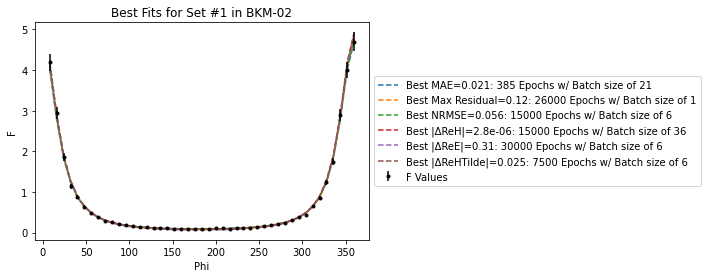

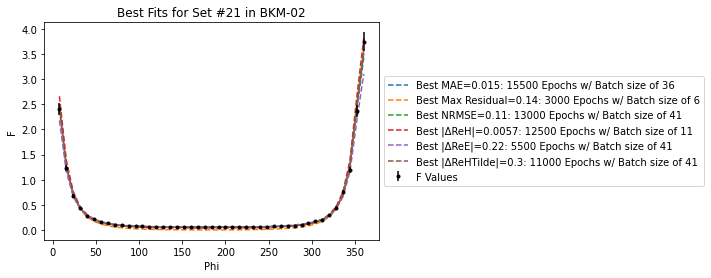

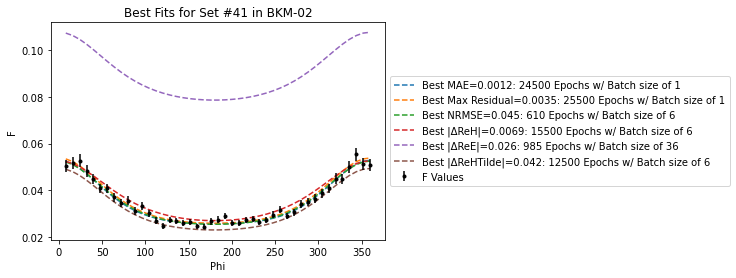

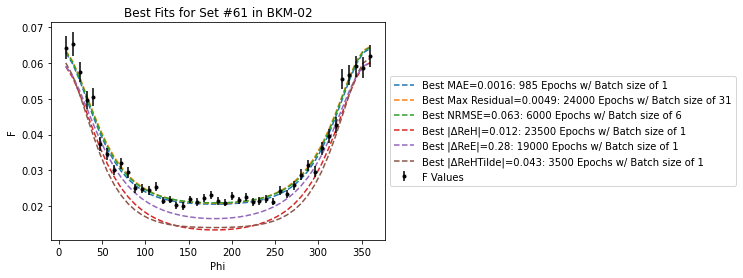

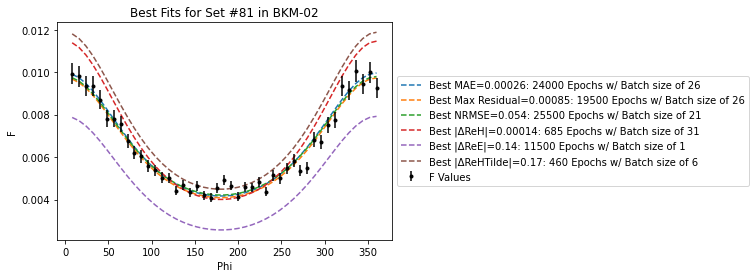

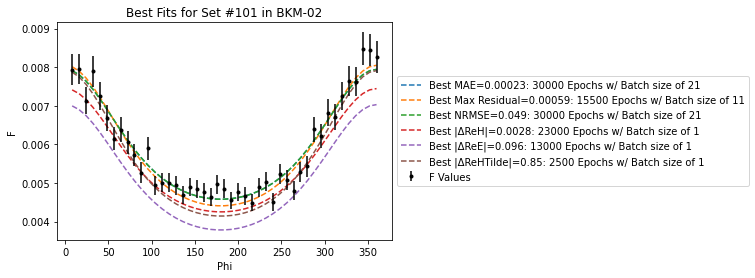

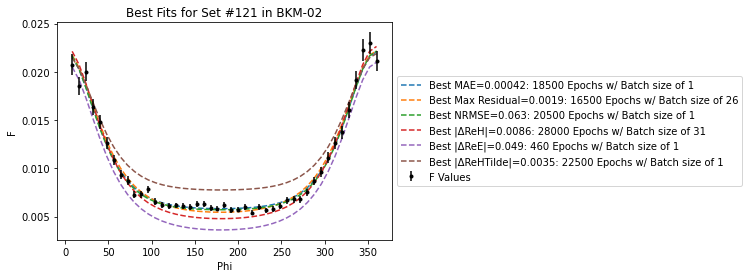

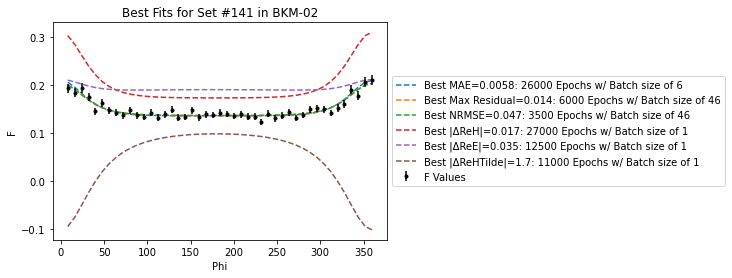

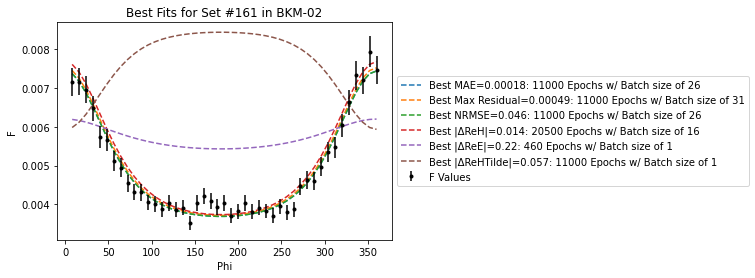

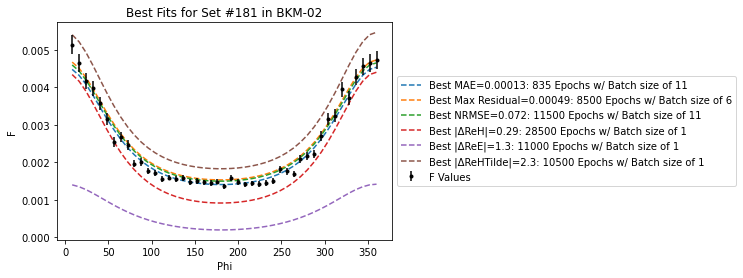

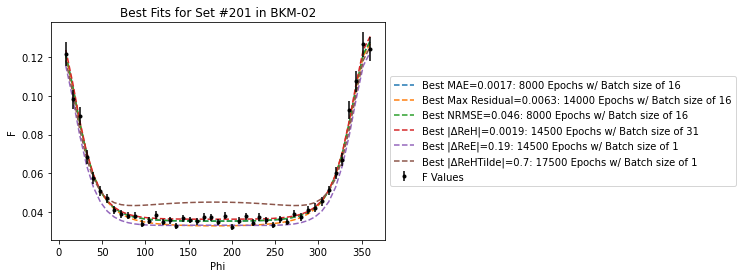

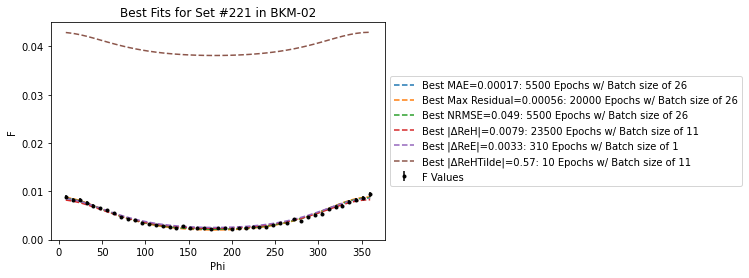

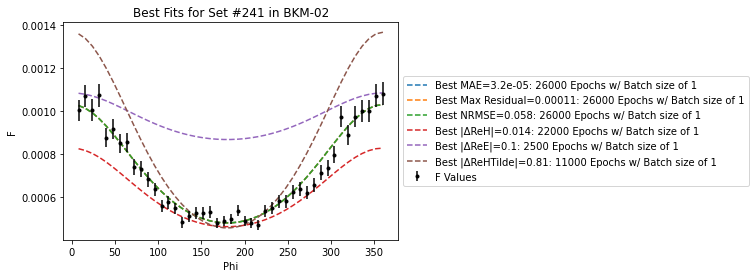

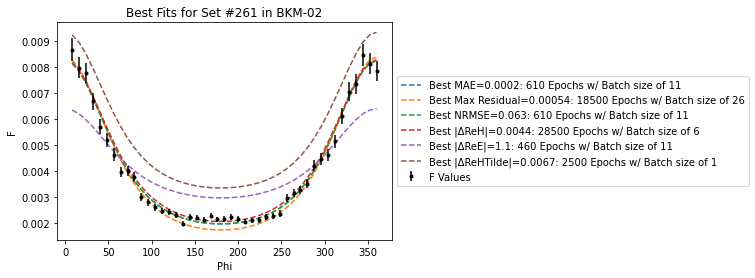

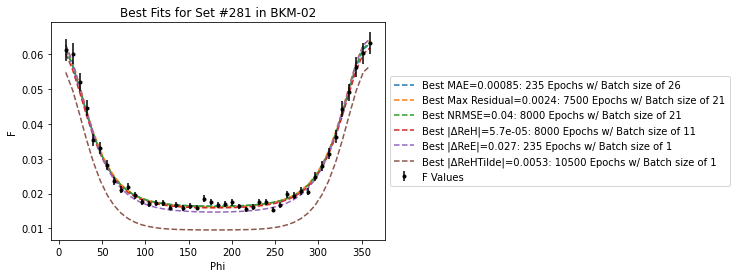

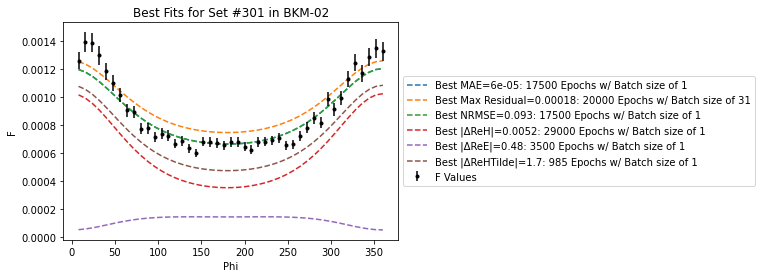

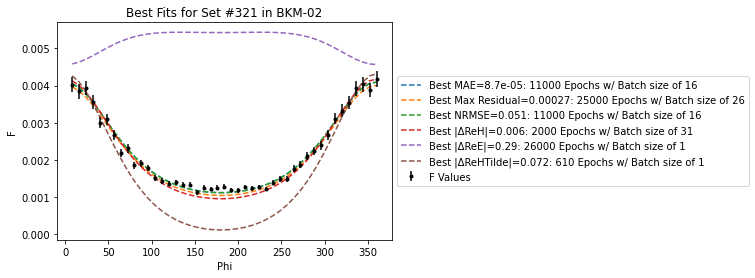

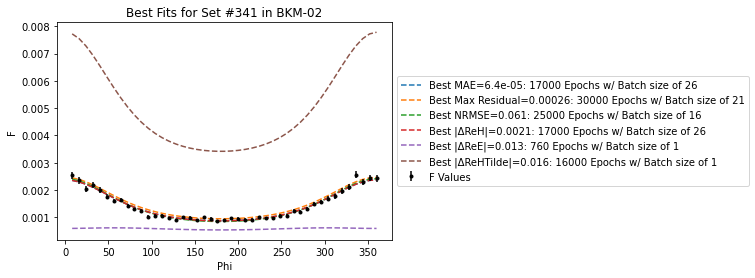

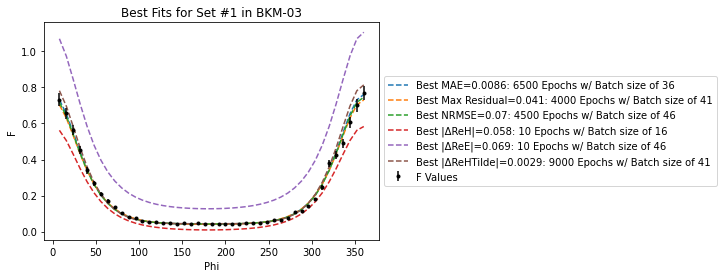

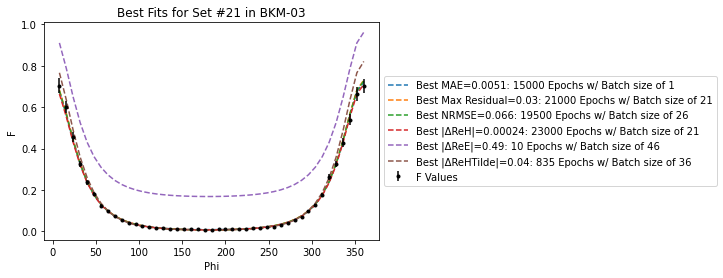

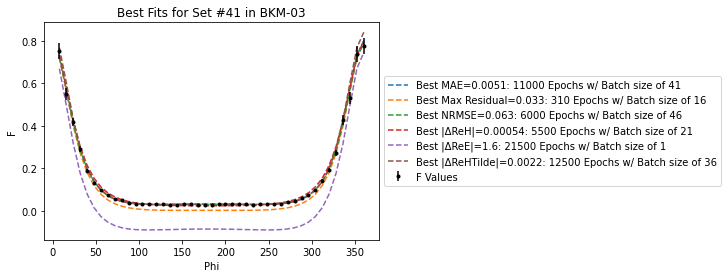

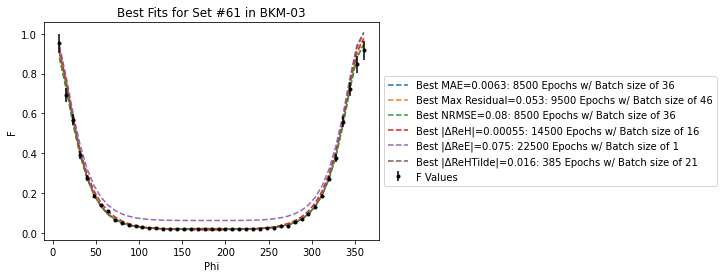

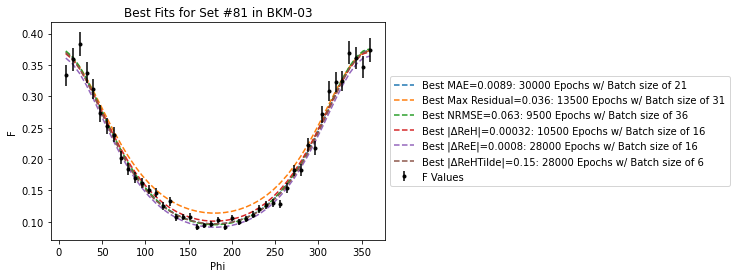

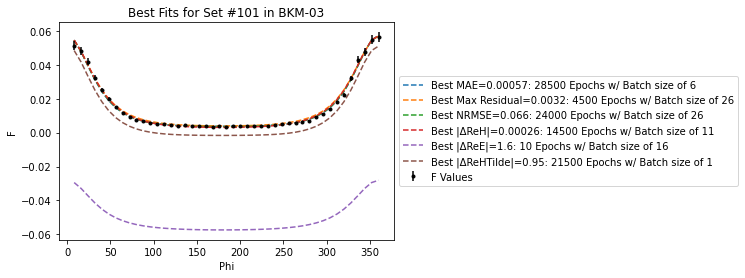

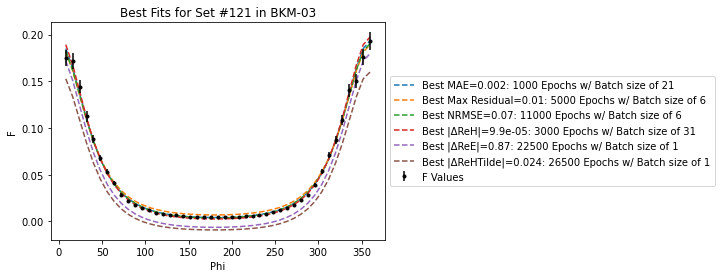

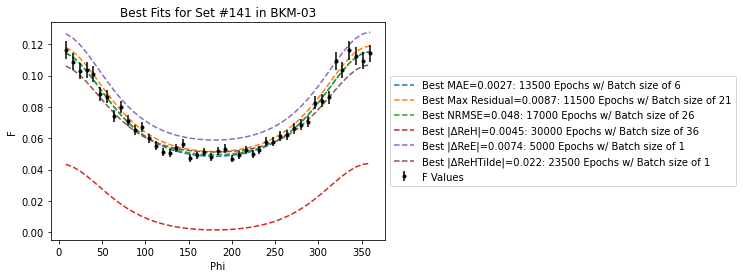

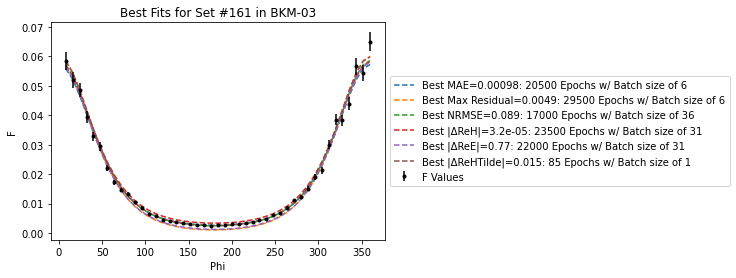

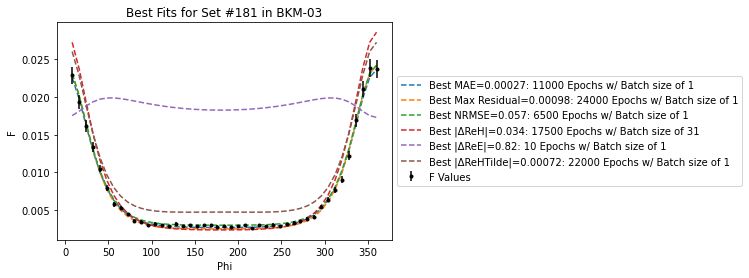

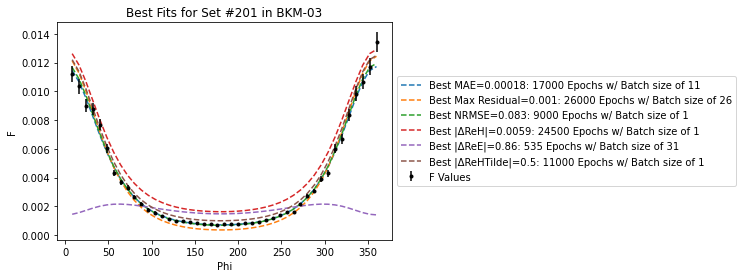

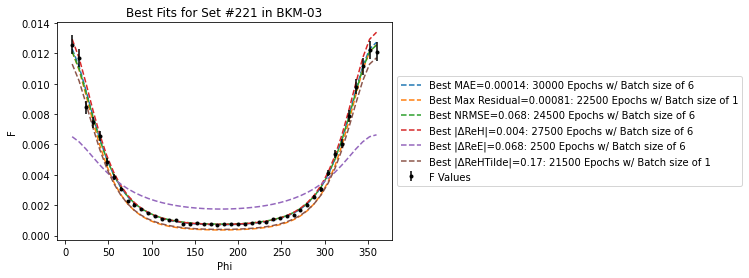

In [18]:
epoch_batch_per_set = {}
for dataset in [2,3]:
    for i in np.arange(1, overall['Set'].max() + 1):
        tempdf = overall.query('(Set==@i) & (BKM==@dataset)')

        if tempdf.empty:
            continue

        plt.figure();
        metric_values = [tempdf['MAE'].idxmin(), tempdf['Max Residual'].idxmin(), tempdf['NRMSE'].idxmin()]
        metric_names = ['MAE', 'Max Residual', 'NRMSE']
        
        for cff in ['ReH', 'ReE', 'ReHTilde']:
            col_name = '|\u0394' + cff + '|'
            metric_values.append(tempdf[col_name].idxmin())
            metric_names.append(col_name)

        epoch_batch_per_set[i] = []

        for n, index in enumerate(metric_values):
            temprow = tempdf.loc[index]
            plt.plot(temprow['phi_x'], temprow['Calculated Points'], linestyle='dashed', 
                     label='Best ' + metric_names[n] + "=" + str(round_to_2(temprow[metric_names[n]])) + ": " + \
                     str(temprow['Epoch']) + ' Epochs w/ Batch size of ' + str(temprow["Batch"]));

            epoch_batch_per_set[i] += [(temprow['Epoch'], temprow['Batch'])]

        plt.errorbar(temprow['phi_x'], temprow['F'], yerr=temprow['sigmaF'], fmt='.', c='black',
                    label='F Values')#, ms=5, mew=0.5, capsize=5);
        plt.xlabel('Phi');
        plt.ylabel('F');
        plt.title('Best Fits for Set #' + str(int(i)) + ' in BKM-0'+str(dataset));
        plt.legend(bbox_to_anchor=[1, 0.5], loc='center left');
        plt.show();